In [1]:
using LinearAlgebra
using Plots
using Optim
using Distributions
# using Interpolations
using FastChebInterp
using QuantEcon
using FastGaussQuadrature

# Double Warm Up #

The following few cells compute Chebyshev Polynomial Approximations to the exponential function $e^x$. I do this to exactly check that my plot matches the class notes. Note that the functions $x_i$ transform the domain into $[-1,1]$ which is where Chebyshev polynomial functions are defined. We thus compute the approximations on this transformed grid. It is then un-transformed using the inverse $b_i$ to back out the true approximation on the original grid.

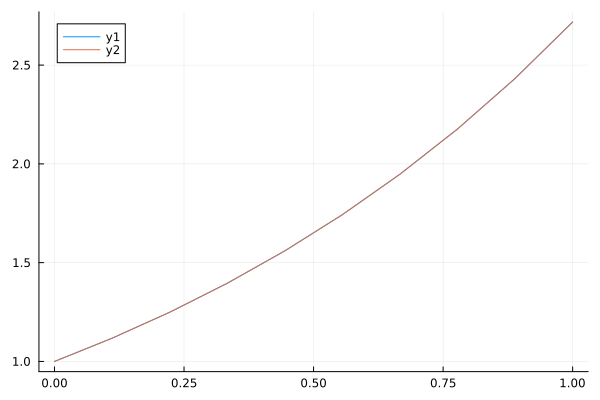

In [2]:
n_domain = 100
n_nodes = 5
b_low_1 = 0
b_high_1 = 1
b_low_2 = -1
b_high_2 = 0



χ_1 = LinRange(0, 1, n_domain)

# Transformation functions with proper broadcasting
x_1(b) = (2 .* b) / (b_high_1 - b_low_1) .- ((b_high_1 + b_low_1) / (b_high_1 - b_low_1))

# Inverse transformation
b_1(x) = ((x .+ 1) .* (b_high_1 - b_low_1)) ./ 2 .+ b_low_1


# Optimal collocation nodes calculation using Chebyshev nodes
optimal_collocation_nodes = zeros(n_nodes)
for i in 1:n_nodes
    optimal_collocation_nodes[i] = cos(((2i-1) / (2 * n_nodes)) * π)
end

# Applying transformations
χ_1_transform = x_1(χ_1)

## Double Warm Up ## Approximate e^y using Chebyshev Polynomials

## Define the Chebyshev Polynomials
p = n_nodes
cheby_init(x) = 1 + 0
cheby_1(x) = x
chebys = [cheby_init, cheby_1]
for i in 3:p
    push!(chebys, x -> 2 .* x .* chebys[i-1](x) .- chebys[i-2](x))
end


Resid_funcs = []

# Array of functions indexed by collocation points

for i in 1:n_nodes
    push!(Resid_funcs, γ -> exp.(b_1(optimal_collocation_nodes[i]))  .- sum(γ[j] .* chebys[j](optimal_collocation_nodes[i])
            for j in 1:n_nodes))
    # Note that the optimal collocation nodes are defined on [-1,1]. The domain above is [-1,1]. 
    # But we want to approximate e^x as if it were on it's true grid. So we jam in the inversion function b_1.
    # That is, we are approximating the true e^x on say [0,1] , but it is transformed to be on [-1,1].
end

function sum_of_squares(γ)
    return sum( f(γ)^2 for f in Resid_funcs )
end

initial_guess = ones(n_nodes)
sum_of_squares(initial_guess)
minim = optimize(sum_of_squares, initial_guess)
minimizer = minim.minimizer

function chebyshev_result(x)
    return sum(minimizer[j] .* chebys[j](x) for j in 1:n_nodes)
end

x_hat = LinRange(0,1,10)
# We computed the approximation on [-1,1]. So make sure the approximator is transformed to x_1(x_hat).
# Then plot over [0,1].
plot(x_hat, chebyshev_result.(x_1(x_hat)))
plot!(x_hat, exp.(x_hat))


# Multivariate Warm up #

We now are going to try to approximate the function $e^y e^x$ with Chebyshev polynomials. This will involve doing a similar procedure to before but with multivariate approximation. Domains will be $\mathcal{T}: [-1,0]\times [0,1]$

In [3]:
n_nodes = 3
# Correcting the function definition for element-wise operations
true_function(x, y) = exp.(x) .* exp.(y)

χ_1 = LinRange(0, 1, n_domain)
χ_2 = LinRange(-1, 0, n_domain)

# Transformation functions with proper broadcasting
x_1(b) = (2 .* b) / (b_high_1 - b_low_1) .- ((b_high_1 + b_low_1) / (b_high_1 - b_low_1))
x_2(b) = (2 .* b) / (b_high_2 - b_low_2) .- (b_high_2 + b_low_2) / (b_high_2 - b_low_2)

# Inverse transformation
b_1(x) = ((x .+ 1) .* (b_high_1 - b_low_1)) ./ 2 .+ b_low_1
b_2(x) = ((x .+ 1) .* (b_high_2 - b_low_2)) ./ 2 .+ b_low_2

# Applying transformations
χ_1_transform = x_1(χ_1)
χ_2_transform = x_2(χ_2)

# 2D grid
# Generate 1D
chebys_nodes = [cos(((2i - 1) / (2 * n_nodes)) * π) for i in 1:n_nodes]
#Generate 2D mesh
grid_points = [(x, y) for x in chebys_nodes, y in chebys_nodes]

## Define the Chebyshev Polynomials
p = n_nodes
cheby_init(x) = 1 + 0
cheby_1(x) = x
chebys = [cheby_init, cheby_1]
for i in 3:p
    push!(chebys, x -> 2 .* x .* chebys[i-1](x) .- chebys[i-2](x))
end

Resid_funcs = []

# Array of functions indexed by collocation points

for i in 1:n_nodes
    for h in 1:n_nodes
        push!(Resid_funcs, γ -> exp.(b_1(chebys_nodes[i])) .* exp.(b_2(chebys_nodes[h]))  
            .-  sum( sum( γ[j,k] .* chebys[j](chebys_nodes[i]) .* chebys[k](chebys_nodes[h])
                    for k in 1:n_nodes ) for j in 1:n_nodes  ) )
#         push!(Resid_funcs, γ -> exp.(b_1(optimal_collocation_nodes[i]))  .- sum(γ[j] .* chebys[j](optimal_collocation_nodes[i])
#                 for j in 1:n_nodes))
        # Note that the optimal collocation nodes are defined on [-1,1]. The domain above is [-1,1]. 
        # But we want to approximate e^x as if it were on it's true grid. So we jam in the inversion function b_1.
        # That is, we are approximating the true e^x on say [0,1] , but it is transformed to be on [-1,1].
    end
end

function sum_of_squares(γ)
    return sum( f(γ)^2 for f in Resid_funcs )
end

initial_guess = ones(n_nodes,n_nodes)
sum_of_squares(initial_guess)
minim = optimize(sum_of_squares, initial_guess)
minimizer = minim.minimizer

function chebyshev_result(x,y)
    return sum(sum(minimizer[j,i] .* chebys[j](x) .* chebys[i](y) for j in 1:n_nodes) for i in 1:n_nodes) # fix here
end

chebyshev_result (generic function with 2 methods)

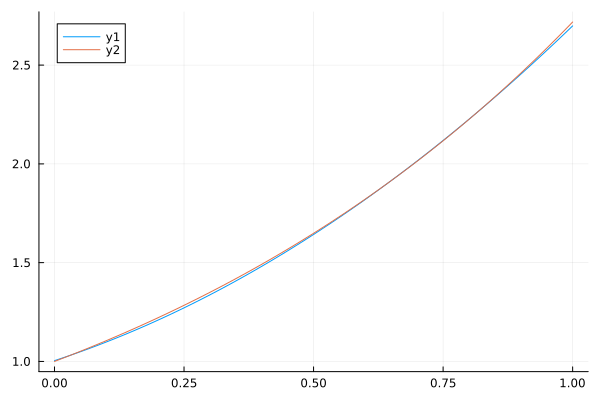

In [4]:
x_hat = LinRange(0,1,100)
y_hat = LinRange(-1,0,100)
plot(x_hat, chebyshev_result.(x_1(x_hat),x_2(0)))
plot!(x_hat, exp.(x_hat).*exp(0))
# x_hat = LinRange(0,1,10)

# plot(x_hat, chebyshev_result.(x_1(x_hat)))
# plot!(x_hat, exp.(x_hat))

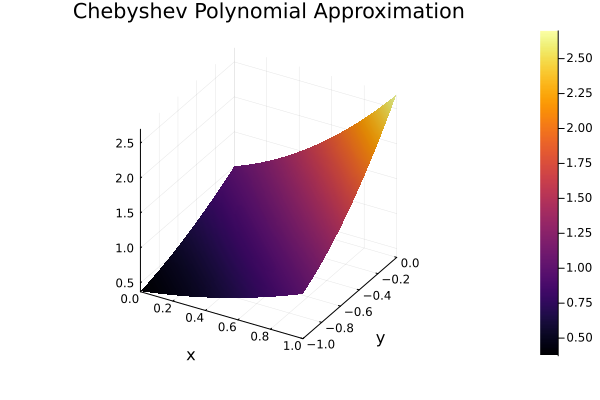

In [5]:
# See approximation here
using Plots
# Calculate the matrix of function values
Z = [chebyshev_result(x_1(x), x_2(y)) for x in x_hat, y in y_hat]
# Optionally, you can create a surface plot in a new window or next plot pane
surface(x_hat, y_hat, Z, title="Chebyshev Polynomial Approximation", xlabel="x", ylabel="y")

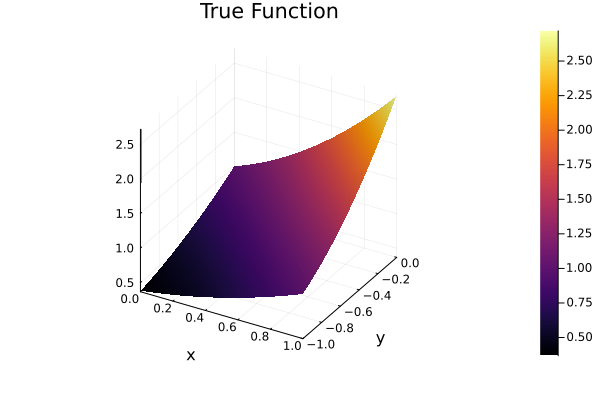

 ***   ALL COLLINEAR DATA POINTS.
   NDP =  100
 ERROR DETECTED IN ROUTINE   IDTANG.
 ***   ALL COLLINEAR DATA POINTS.
   NDP =  100
 ERROR DETECTED IN ROUTINE   IDTANG.
 ***   ALL COLLINEAR DATA POINTS.
   NDP =  100
 ERROR DETECTED IN ROUTINE   IDTANG.


In [6]:
# See true plot here
surface!(x_hat, y_hat, exp.(x_hat) .* exp.(y_hat), title = "True Function" )

# Recursive Equilibrium #

A Recursive Equilibrium is a value of default, $v^d(y)$; a value function of no default, $v^{n d}(b, y)$; and a pricing schedule $q\left(b^{\prime}, y\right)$ such that

1. $ v^d(y)$ solves the functional equation

$$
v^d(y)=u(h(y))+\beta \mathbb{E}_y\left[\theta v^{n d}\left(0, y^{\prime}\right)+(1-\theta) v^d\left(y^{\prime}\right)\right]
$$




2. Taking as given the bond price function, $v^{n d}(b, s)$ solves

$$
v^{n d}(b, y)=\max _{b^{\prime}}\left\{u\left(y-b+q\left(b^{\prime}, y\right) b^{\prime}\right)+\beta \mathbb{E}_y\left[\max \left\{v^{n d}\left(b^{\prime}, y^{\prime}\right), v^d\left(y^{\prime}\right)\right\}\right]\right\}
$$



3. $ q\left(b^{\prime}, y\right)$ is defined by
$$
q\left(b^{\prime}, y\right)=\frac{\mathbb{E}_y\left[1-\mathbf{1}_{ v^{n d}\left(b^{\prime}, y^{\prime}\right) \leq v^d\left(y^{\prime}\right)}\right]}{1+r}
$$

## Interpolation outside of the grid ## 
is done with a first order Taylor expansion at the edge along the y dimension. I rule out selection of $b^\prime$ outside of the grid, although this can also be easily done. In another version of the code I also implemented the Tauchen method instead of Gauss-Hermitian Quadrature. In this case the $y$ state space is bounded and so we don't need to employ extrapolation. However, the results were worse with that version of the code so I proceed with this.

# Computation and Simulation #

The following code implements the sovereign default model of Arellano (2008), using the projection method. The structure of the algorithm is found in the second set of slides for the class.


In [7]:
# Set the parameters
const ρ = 0.945
const sigma_u = 0.025
const A = 10
const Ey = A * exp(sigma_u^2 / 2)
const threshold = 0.969 * Ey

const θ = 0.282
const β = 0.95
const r = 0.017 # 0.017
const σ = 2

# Define the grids
const b_min = -0.38
const b_max = 3.5
const nb = 100

const y_max = A * exp(4 * sigma_u)
const y_min = A * exp(-4 * sigma_u)
const ny = 25

const lb = [b_min, y_min]
const ub = [b_max, y_max]
b_grid = LinRange(b_min, b_max, nb)
y_grid = LinRange(y_min, y_max, ny)

b_y_grid = [[b, y] for b in b_grid, y in y_grid]

function b_y_mesh(b,y)
    # b is scalar, y is vector
    return [[b, y[i]] for i in 1:length(y)]
end

# Chebyshev Approximation Parameters
order_y = 25
order_b = 40
# Get Chebyshev zeros
y_points = chebpoints(order_y, y_min, y_max);
b_y_points = chebpoints((order_b, order_y), lb, ub);

In [8]:
function u(c; σ = σ ) 
    if c > 0.0001
        return (c^(1-σ) -1) / (1 - σ)
    else
        return -888888888
    end
end

h(y, threshold = threshold) = min(y, threshold)

h (generic function with 2 methods)

In [9]:
epsilons, PIs = gausshermite(ny);
PIs = PIs/ sqrt(pi);
epsilons = 2^(1/2) * sigma_u .* epsilons;
epsilons = (A^(1 - ρ)) * exp.(epsilons);

function y_prime(y; ρ = ρ, epsilons = epsilons)
    return y^ρ.*(epsilons)
end

y_prime (generic function with 1 method)

In [10]:
function v_d_update(v_d, v_nd; θ = θ, β = β, PIs = PIs, epsilons = epsilons)
    function v_d_new(y)
        y_prime_val = y_prime(y)
        return u(h(y)) + β * dot(θ .* v_nd.(b_y_mesh(0, y_prime_val)) .+ (1 - θ) .* v_d.(y_prime_val), PIs)
    end
    return v_d_new
end

function v_nd_update(v_d, v_nd, q; β = β, PIs = PIs, epsilons = epsilons)
    function v_nd_hat(b, y, b_prime)
        y_prime_val = y_prime(y)
        return u(y - b + q(b_prime, y) * b_prime) + β * dot(max.(v_nd.(b_y_mesh(b_prime, y_prime_val)), v_d.(y_prime_val)), PIs) 
    end
    function v_nd_new(x) 
        hat_vals = [v_nd_hat(x[1], x[2], b_grid[i]) for i in 1:length(b_grid)]
        return maximum(hat_vals)
    end
    return v_nd_new
end

function v_d_cheb(v_d_new)
    cheb_approx = chebinterp(v_d_new.(y_points), y_min, y_max)
    val_max, grad_max = chebgradient(cheb_approx, y_max)
    val_min, grad_min = chebgradient(cheb_approx, y_min)
    function cheb_extrap(y)
        if y <= y_max && y >= y_min
            return cheb_approx(y)
        end
        if y > y_max
            return val_max + grad_max * (y - y_max)
        end
        if y < y_min
            return val_min + grad_min * (y - y_min)
        end
    end
    return cheb_extrap
end

function v_nd_cheb(v_nd_new)
    cheb_approx = chebinterp(v_nd_new.(b_y_points), lb, ub)
    function cheb_extrap(x)        
        if x[1] >= b_min && x[1] <= b_max && x[2] >= y_min && x[2] <= y_max
            return cheb_approx(x)
        end
        if x[2] < y_min
            edge_point = [x[1], y_min]
            val, grad = chebgradient(cheb_approx, edge_point)
            return val + dot(grad, x - edge_point)
        end
        if x[1] >= b_min && x[1] <= x[2] > y_max
            edge_point = [x[1], y_max]
            val, grad = chebgradient(cheb_approx, edge_point)
            return val + dot(grad, x - edge_point)
        end
    end
    return cheb_extrap
end

function q_update(v_d, v_nd)
    q(b_prime, y) = dot(v_nd.(b_y_mesh(b_prime, y_prime(y))) .> v_d.(y_prime(y)), PIs) / (1+r)
    return q
end

q_update (generic function with 1 method)

In [11]:
v_d_guess(y) = 1
v_nd_guess(x) = 1
q_guess(x) = 1 # q_update(v_d_guess, v_nd_guess)

q_guess (generic function with 1 method)

In [12]:
err = 10
its = 0
maxits = 100
tol = 1e-03
V_d = v_d_guess
V_nd = v_nd_guess
q = q_guess


for i in 1:maxits # for loop runs faster, but less flexibility
    V_d_new = v_d_update(V_d, V_nd; PIs = PIs, epsilons = epsilons)
    V_d_new = v_d_cheb(V_d_new)
    q_new = q_update(V_d_new, V_nd)
    
    V_nd_new= v_nd_update(V_d_new, V_nd, q_new; PIs = PIs, epsilons = epsilons)
    V_nd_new = v_nd_cheb(V_nd_new)
    
    its = its + 1
    println("Iteration: ", its)
    if its % 5 == 0
        V_d_vec = V_d.(y_grid)
        V_d_new_vec = V_d_new.(y_grid)
        err = maximum(abs.(V_d_vec .- V_d_new_vec))
        println("Error: ", err)
    end
    V_d = V_d_new
    V_nd = V_nd_new
    q    = q_new
end


Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Error: 0.8403360730981255
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Error: 0.6051853930137572
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Error: 0.4358783105924058
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Error: 0.3139842994089914
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Error: 0.22621029901598533
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Error: 0.162991998810309
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Error: 0.11745114409744417
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Error: 0.08463988972965097
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Error: 0.06100115656223082
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Error: 0.044159930491041166
Iteration: 51
Iteration: 52
Iteration: 53
It

In [13]:
nyy = 100
nbb = 250
y_grid_new = LinRange(y_min, y_max, nyy)
b_grid_new = LinRange(b_min, b_max, nbb)
V_nd_array = zeros(nbb)
for i in enumerate(b_grid_new)
    ind_b = i[1]
    b = i[2]
    V_nd_array[ind_b] = V_nd([b,y_grid_new[50]])
end

epsilons, PIs = gausshermite(nyy);
PIs = PIs/ sqrt(pi);
epsilons = 2^(1/2) * sigma_u .* epsilons;
epsilons = (A^(1 - ρ)) * exp.(epsilons);

order_y = 50
order_b = 75

y_points = chebpoints(order_y, y_min, y_max);
b_y_points = chebpoints((order_b, order_y), lb, ub);

## Do a final single iteration on a fine grid to enhance smoothness
V_d_new = v_d_update(V_d, V_nd; PIs = PIs, epsilons = epsilons)
V_d_new = v_d_cheb(V_d_new)
q_new = q_update(V_d_new, V_nd)

V_nd_new = v_nd_update(V_d_new, V_nd, q_new; PIs = PIs, epsilons = epsilons)
V_nd_new = v_nd_cheb(V_nd_new)

its = its + 1

V_d = V_d_new
V_nd = V_nd_new
q    = q_new


q (generic function with 1 method)

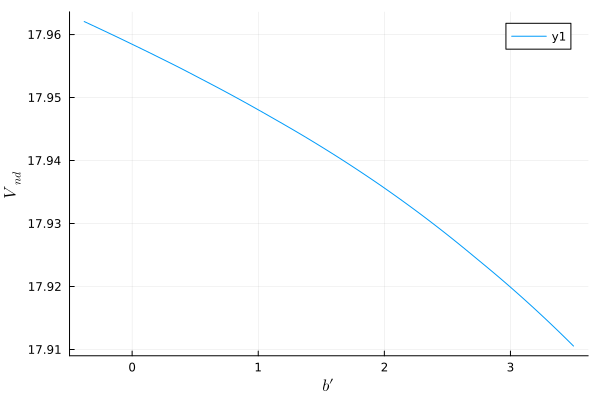

In [14]:
z = [q(bi, yi) for yi in y_grid_new, bi in b_grid_new]
z2 = [1 - (1+ r) * q(bi, yi) for yi in y_grid_new, bi in b_grid_new]

z_partial_1 = [q(bi, y_grid_new[10]) for bi in b_grid_new]

z_partial_2 = [q(bi, y_grid_new[90]) for bi in b_grid_new]

using LaTeXStrings

plot(b_grid_new, V_nd_array, xlabel=L"b\prime", ylabel=L"V_{nd}")

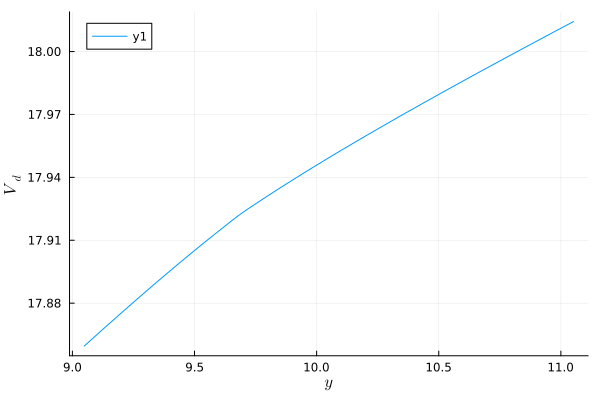

In [15]:
plot(y_grid_new, V_d.(y_grid_new), xlabel=L"y", ylabel=L"V_{d}")

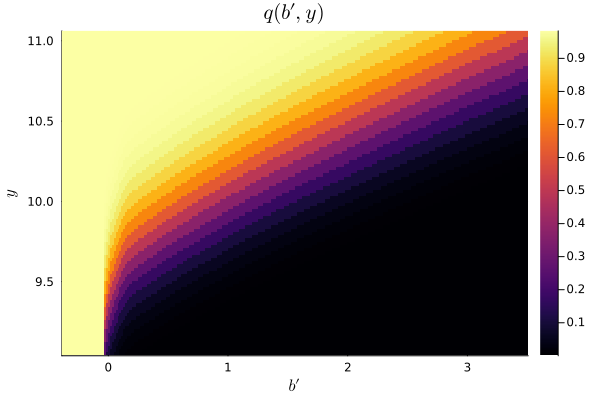

In [16]:
using LaTeXStrings
heatmap(b_grid_new, y_grid_new, z, title=title=L"q(b\prime,y)", xlabel=L"b\prime", ylabel=L"y")

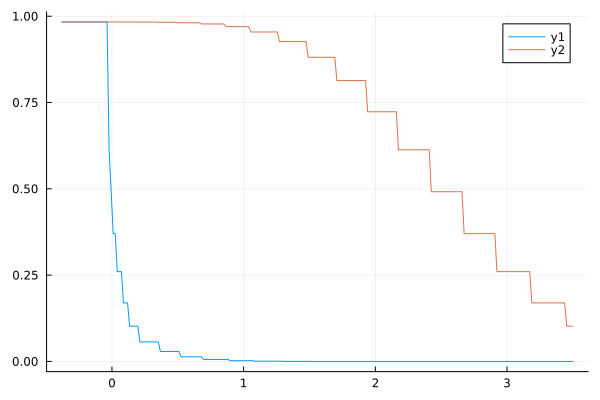

In [17]:
z_partial_1 = [q(bi, y_grid_new[15]) for bi in b_grid_new]
z_partial_2 = [q(bi, y_grid_new[80]) for bi in b_grid_new]
plot(b_grid_new, z_partial_1)
plot!(b_grid_new, z_partial_2)

# Simulations #

In [26]:
using Random

function b_prime_star(b::Float64,y::Float64, v_d, v_nd)::Float64
    function v_nd_hat(b, y, b_prime)
        y_prime_val = y_prime(y)
        return u(y - b + q(b_prime, y) * b_prime) + β * dot(max.(v_nd.(b_y_mesh(b_prime, y_prime_val)), v_d.(y_prime_val)), PIs) 
    end
    hat_vals = [v_nd_hat(b, y, b_grid[i]) for i in 1:length(b_grid)]
    return b_grid[argmax(hat_vals)]
end



default_pol(b::Float64,y::Float64, v_d, v_nd)::Int = Int(v_d(y) > v_nd([b,y]))




default_pol (generic function with 1 method)

In [27]:
function y_prime_sim(y; ρ = ρ, epsilons = epsilons)
    random_epsilon = epsilons[rand(1:length(epsilons))]  # Select one random epsilon each time
    return y^ρ * random_epsilon
end

y_prime_sim (generic function with 1 method)

In [28]:

num_steps = 500
b_init = 0
y = zeros(num_steps)
y_init = mean(y_grid)
y[1] = y_init


epsilon_shocks = rand(Normal(0, sigma_u), num_steps)

y[1] = y_init
for t in 2:num_steps
    y[t] = A^(1-ρ)*y[t-1]^ρ * exp(epsilon_shocks[t])
end

# Perform Bernoulli trials
θ_vec = rand(Bernoulli(θ), num_steps)


# Default entry and reentry Bernoulli trials
# p = 0.282  # Probability of success

# Perform Bernoulli trials
θ_vec = rand(Bernoulli(θ), num_steps)


500-element Vector{Bool}:
 0
 0
 0
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 1
 1
 1
 0
 0
 0
 1
 0
 1

In [29]:
using Random

function b_prime_star(b::Float64,y::Float64, v_d, v_nd)::Float64
    function v_nd_hat(b, y, b_prime)
        y_prime_val = y_prime(y)
        return u(y - b + q(b_prime, y) * b_prime) + β * dot(max.(v_nd.(b_y_mesh(b_prime, y_prime_val)), v_d.(y_prime_val)), PIs) 
    end
    hat_vals = [v_nd_hat(b, y, b_grid[i]) for i in 1:length(b_grid)]
    return b_grid[argmax(hat_vals)]
end



default_pol(b::Float64,y::Float64, v_d, v_nd)::Int = Int(v_d(y) > v_nd([b,y]))




V_nd_sim = zeros(num_steps)
V_d_sim = zeros(num_steps)
VV_sim  = zeros(num_steps)
default_regime = zeros(num_steps)
defaults = zeros(num_steps)
entrances = zeros(num_steps)
q_sim   = zeros(num_steps)
b_init = 0
b_vec = zeros(num_steps)
b_vec[1] = b_init


V_nd_sim[1] = V_nd([b_init, y_init])
V_d_sim[1]  = 0 ## In states of non-default set shadow values to 0
VV_sim[1]   = max(V_nd([b_init, y_init]), V_d(y_init))
q_sim[1] = q(b_init, y_init)

y[75] = 8.5
for t in 2:num_steps
    println(t)
    # ==================================== DEFAULT CHOICE ======================================
    if default_regime[t-1] == 0 # come into the period in good standing
        default_regime[t] = default_pol(b_vec[t-1], y[t], V_d, V_nd)
        if default_regime[t] == 1
            defaults[t] = 1
        end
        
    else # come into the period defaulted
        default_regime[t] = Int(1 - θ_vec[t]) # re-enter?
    end
    
    # ==================================== DEBT CHOICE ============================================
    
    if default_regime[t-1] == 1 && default_regime[t] == 1 ## enter in default, stay in default
        b_vec[t]  = 0
        VV_sim[t] = V_d(y[t])
        
    elseif  default_regime[t-1] == 0 && default_regime[t] == 1 ## enter in good standing, then default
        defaults[t] = 1
        b_vec[t] = 0
        VV_sim[t] = V_d(y[t])
        
    elseif  default_regime[t-1] == 1 && default_regime[t] == 0 ## enter in default, then re-enter
        entrances[t] = 1
        VV_sim[t] = V_nd([0, y[t]])
        q_sim[t] = q(0,y[t])
        b_vec[t] = b_prime_star(b_vec[t-1], y[t], V_d, V_nd)
        
    elseif  default_regime[t-1] == 0 && default_regime[t] == 0 ## enter in good standing, stay in good standing
        b_vec[t] = b_prime_star(b_vec[t-1], y[t], V_d, V_nd)
        VV_sim[t] = V_nd([b_vec[t-1], y[t]])
        q_sim[t]  = q(b_vec[t],y[t])
    end
    
end


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

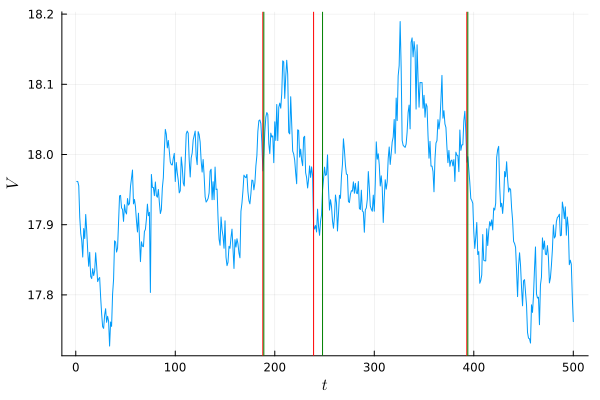

In [30]:
plt = plot(1:num_steps, VV_sim, label = false, xlabel=L"t", ylabel=L"V")
# plt22 = plot!(1:num_steps,V_d.(y))
# display(plot())
# Adding vertical lines for defaults
for (index, value) in enumerate(defaults)
    if value == 1
        vline!(plt,[index], label = false, color=:red)
    end
end
for (index, value) in enumerate(entrances)
    if value == 1
        vline!(plt,[index], label = false, color=:green)
    end
end
display(plt)

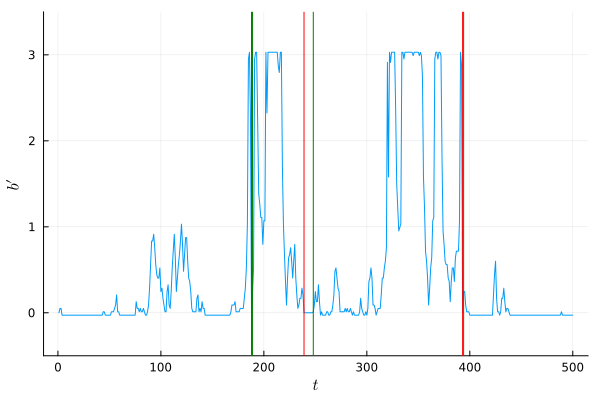

In [31]:
plt2 = plot(1:num_steps, b_vec, ylim=(-0.5, 3.5), label = false, xlabel=L"t", ylabel=L"b\prime")
for (index, value) in enumerate(defaults)
    if value == 1
        vline!(plt2,[index], label = false, color=:red)
    end
end
for (index, value) in enumerate(entrances)
    if value == 1
        vline!(plt2,[index], label = false, color=:green)
    end
end
display(plt2)

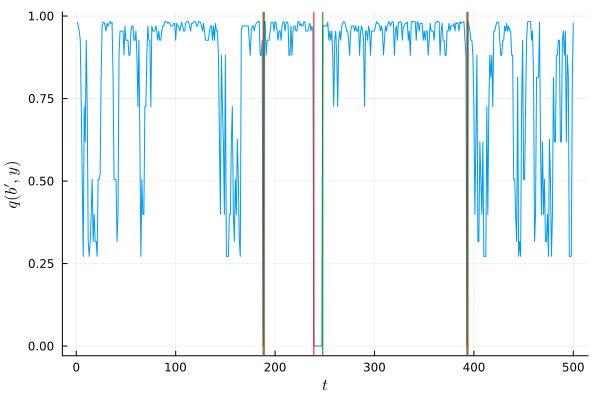

In [32]:
plt3 = plot(1:num_steps, q_sim, label = false, xlabel=L"t", ylabel=L"q(b\prime,y)")
for (index, value) in enumerate(defaults)
    if value == 1
        vline!(plt3,[index], label = false, color=:red)
    end
end
for (index, value) in enumerate(entrances)
    if value == 1
        vline!(plt3,[index], label = false, color=:green)
    end
end
display(plt3)

In [33]:
using DataFrames

# Calculations
std_y = std(y)
b_y_ratio = mean(b_vec ./ y)
default_probability = sum(defaults) / num_steps

# Calculation for c vector
c_vec = zeros(num_steps)
for t in 2:num_steps
    c_vec[t] = y[t] - b_vec[t-1] + q_sim[t] * b_vec[t]
end

# Correlations
cor_c_y = cor(c_vec, y)
cor_b_y = cor(b_vec, y)

# Mean spread calculation
q_pos = q_sim
ind = 0
for i in 1:num_steps
   if q_pos[i] ==0
        ind = ind + 1
    end
end
mean_spread = (1/(1+r)) .- sum(q_sim)/(num_steps - ind)
# mean_spread = mean(1/(1+r) .- q_sim)

# Create a DataFrame to store the results
results = DataFrame(
    Std_Y = [std_y],
    B_Y_Ratio = [b_y_ratio],
    Default_Probability = [default_probability],
    Correlation_C_Y = [cor_c_y],
    Correlation_B_Y = [cor_b_y],
    Mean_Spread = [mean_spread]
)
# Print the DataFrame
println("Computed Results:")
print(results)

Computed Results:
1×6 DataFrame
 Row │ Std_Y     B_Y_Ratio  Default_Probability  Correlation_C_Y  Correlation_B_Y  Mean_Spread 
     │ Float64   Float64    Float64              Float64          Float64          Float64     
─────┼─────────────────────────────────────────────────────────────────────────────────────────
   1 │ 0.877891     0.0461                0.006          0.83815         0.770599     0.137071